## Reduced Rank Regression

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random


sys.path.append(os.path.join(os.getcwd(), 'utils'))

from utils.data_loading import *
from utils.data_processing import *
from utils.regression import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# autoreload
%reload_ext autoreload
%autoreload 2

# Get the current working directory
current_dir = os.getcwd()

# Define the path to the data
data_path = os.path.join(current_dir, 'data')

print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Load the data
current_dir = os.getcwd()
print("Loading the data...")
data_path = os.path.join(current_dir, 'data')
data = load_data(data_path, 'ssp585_time_series.pkl')
print("Data loaded successfully!")

Loading the data...
Loading data from ssp585_time_series.pkl
Data loaded successfully.
Data loaded successfully!


In [3]:
filtered_data = filter_data(data)

Filtering data...


100%|██████████| 72/72 [00:00<00:00, 63138.17it/s]

Data filtered. Kept 34 models


In [4]:
# Print the shape of the first run in the first model of filtered_data
first_model = list(filtered_data.keys())[0]
first_run = list(filtered_data[first_model].keys())[0]
print(f"Shape of the first run in the first model: {filtered_data[first_model][first_run].shape}")

Shape of the first run in the first model: (165, 72, 144)


In [5]:
# Create a NaN mask to remove any cells which have 1 >= NaNs

nan_mask = create_nan_mask(filtered_data)

Creating NaN mask...


100%|██████████| 34/34 [00:02<00:00, 14.82it/s]

NaN mask created.


In [6]:
# Apply the NaN mask to every single run (modifications done in place for memory efficiency)

masked_data = mask_out_nans(filtered_data, nan_mask)

Masking out NaN values...


100%|██████████| 34/34 [00:01<00:00, 24.35it/s]

NaN values masked out.


In [7]:
# Print the shape of the first run in the first model of masked_data
first_model = list(masked_data.keys())[0]
first_run = list(masked_data[first_model].keys())[0]
print(f"Shape of the first run in the first model: {masked_data[first_model][first_run].shape}")

Shape of the first run in the first model: (165, 72, 144)


## The NaN mask has been applied and only the models with more than 4 runs have been kept

In [8]:
print(f"There are exactly {len(masked_data.keys())} models of the {len(data.keys())} that remain.")

There are exactly 34 models of the 72 that remain.


## Only keep 15 models to make processing time faster

In [9]:
selected_models = random.sample(list(masked_data.keys()), 15)
selected_models.append('CanESM5-1')
masked_data = {model: masked_data[model] for model in selected_models}

In [10]:
reshaped_data = reshape_data(masked_data)

Reshaping data...


100%|██████████| 16/16 [00:01<00:00, 10.98it/s]

Data reshaped.


In [11]:
example_model = 'CanESM5-1'
example_model_data = reshaped_data[example_model]
print(f"Selected model: {example_model}, which has {len(example_model_data)} runs.")

Selected model: CanESM5-1, which has 72 runs.


In [12]:
first_example_model_run = example_model_data[list(example_model_data.keys())[0]]
first_example_model_run.shape # Shape: (Time x (Latitude x Longitude))

(165, 10368)

### Calculate the forced response for each model, assuming that it is the mean of all the runs

In [13]:
data_forced_responses = add_forced_response(reshaped_data) # The forced response is not correctly normalized yet (this is done by the normalize function below)

Adding the forced response to the data...


100%|██████████| 16/16 [00:02<00:00,  7.42it/s]

Forced response added.


In [14]:
# Print the shape of a random run from a random model

random_model = random.choice(list(data_forced_responses.keys()))
random_run = random.choice(list(data_forced_responses[random_model].keys()))
print(f"Shape of the random run: {data_forced_responses[random_model][random_run].shape}")

Shape of the random run: (165, 10368)


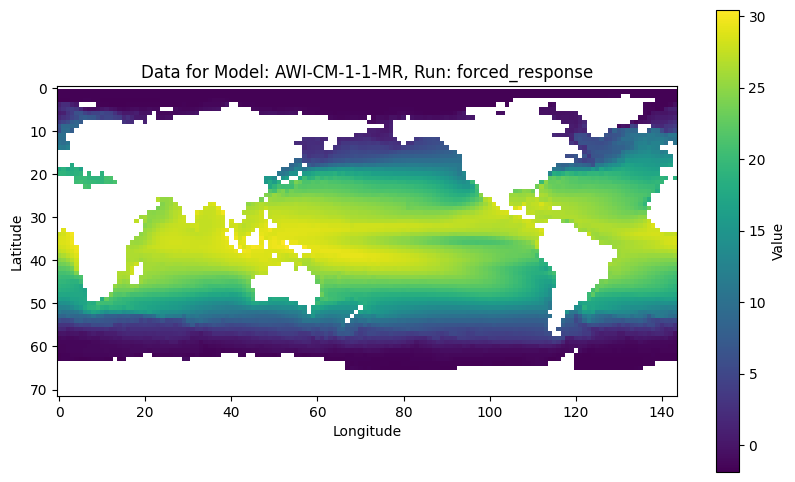

In [15]:
# Reshape the data to the original grid shape
data_grid = data_forced_responses[random_model][random_run][0].reshape(72, 144)

# Plot the data using plt.imshow
plt.figure(figsize=(10, 6))
plt.imshow(data_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Data for Model: {random_model}, Run: {random_run}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## At this point, the data still contains NaNs, corresponding to the continents

In [16]:
data_without_nans = remove_nans_from_grid(data_forced_responses, nan_mask)

Removing NaN values from the grid...


100%|██████████| 16/16 [00:00<00:00, 30.69it/s]

NaN values removed.


In [17]:
len(data_without_nans.keys())

16

In [18]:
# Print the shape of a random run from a random model (same as above)
print(f"The shape of the data without NaNs: {data_without_nans[random_model][random_run].shape}")

The shape of the data without NaNs: (165, 6523)


## Now the NaNs have been completely removed from the data

### The data is now in the shape : Time x # of grid cells without NaNs

In [19]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data_without_nans.keys()))
train_models = [model for model in data_without_nans.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data_without_nans[model] for model in train_models}
test_data = {test_model: data_without_nans[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['IPSL-CM6A-LR', 'AWI-CM-1-1-MR', 'HadGEM3-GC31-MM', 'CAS-ESM2-0', 'ACCESS-CM2', 'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'GISS-E2-2-G', 'NorCPM1', 'MIROC6', 'CESM2-FV2', 'FGOALS-g3', 'CMCC-CM2-SR5', 'CNRM-ESM2-1', 'CanESM5-1']
Testing model: E3SM-2-0


In [20]:
# Normalize the data
normalized_train_data, normalized_test_data, training_statistics, testing_statistics = normalize_data(train_data, test_data)

Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

Data normalization completed.


Selected model: ACCESS-CM2, run: r2i1p1f1.
Shape of the normalized data: (165, 6523).
Shape of the original data: (165, 6523).


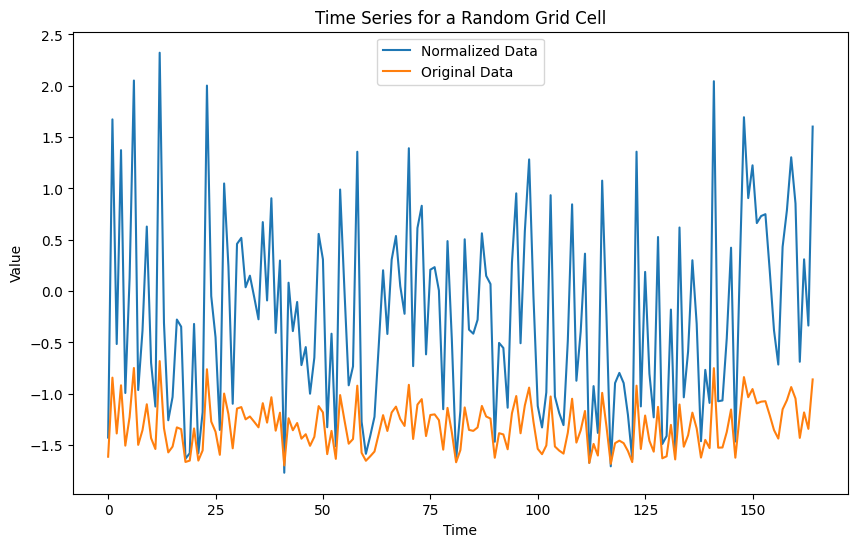

In [21]:
# make a few plots using normalized_train_data and train_data by selecting a random grid cell and plotting the time series
random_model = random.choice(list(normalized_train_data.keys()))
random_run = random.choice(list(normalized_train_data[random_model].keys()))

print(f"Selected model: {random_model}, run: {random_run}.")

# print dimensions of the data
print(f"Shape of the normalized data: {normalized_train_data[random_model][random_run].shape}.")
print(f"Shape of the original data: {train_data[random_model][random_run].shape}.")

# select a random grid cell
random_cell = random.randint(0, 6523)
time_series_normalized = normalized_train_data[random_model][random_run][:, random_cell]
time_series_original = train_data[random_model][random_run][:, random_cell]

# plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series_normalized, label='Normalized Data')
plt.plot(time_series_original, label='Original Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series for a Random Grid Cell')
plt.legend()
plt.show()

## Now that the data has been normalized (and NaN values removed), it's time to do the Reduced Rank Regression (RRR)

In [22]:
# First pool the data together
X_full, Y_full = pool_data(normalized_train_data)

Pooling data...


100%|██████████| 15/15 [00:00<00:00, 178734.55it/s]


Data pooled.


In [23]:
X_full.shape, Y_full.shape # Shape is correct

((48345, 6523), (48345, 6523))

In [24]:
rank = 10 # Used as a starting point
lambda_ = 1 # This will be optimized later
Brr, B_ols = reduced_rank_regression(X_full, Y_full, rank, lambda_)

Fitting OLS...
RRR completed.


## Plot the MSE for on the Training dataset

100%|██████████| 15/15 [00:14<00:00,  1.05it/s]
/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_3495/1473404141.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels)


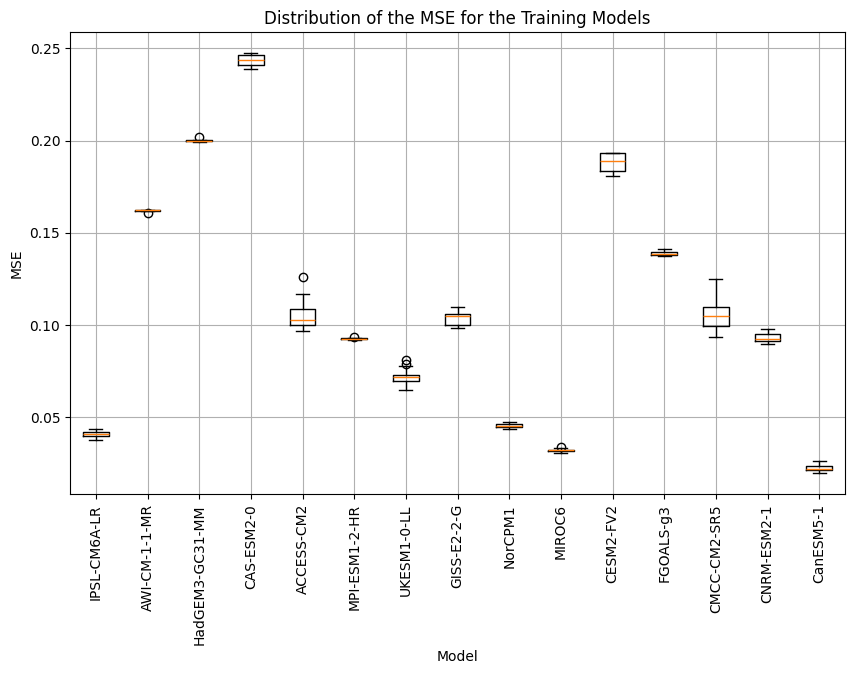

In [25]:
# Plot the distribution of the MSE by taking the average MSE for each model and make a boxplot

mse_values_train = calculate_mse_distribution(normalized_train_data, Brr)
labels = list(mse_values_train.keys())
values = list(mse_values_train.values())
plt.figure(figsize=(10, 6))
plt.boxplot(values, labels=labels)
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Distribution of the MSE for the Training Models')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [26]:
mse_values_train

{'IPSL-CM6A-LR': [0.03908818625781382,
  0.039972307181211225,
  0.0413582999991793,
  0.041916655128168466,
  0.04062157319042228,
  0.04293113062745925,
  0.041807655360920105,
  0.03839906515895592,
  0.0375816845076968,
  0.039348966822744184,
  0.041877226620017464,
  0.04032433965376068,
  0.040987668526150135,
  0.041650892118355196,
  0.04080045209517182,
  0.04138970477203216,
  0.04355317378604495,
  0.04389589059161139,
  0.039777809059023006,
  0.04187040314209419,
  0.04330170220345539,
  0.03925743962684074,
  0.04077164882422674,
  0.043647370269334004,
  0.03976831216210744,
  0.04074839241908628,
  0.04033637189386758,
  0.03979732263064536,
  0.03921035198927336,
  0.03978439421597889,
  0.040068846086390296,
  0.04154539333311156,
  0.04167553919652736],
 'AWI-CM-1-1-MR': [0.1625337888410343,
  0.16215379369503072,
  0.16233056373686755,
  0.1609129062081832,
  0.16208751988382766],
 'HadGEM3-GC31-MM': [0.2019757261807719,
  0.19990134376535285,
  0.19985274756540858

In [28]:
# Do a Sanity check to see if the rank is correct and if Brr is sparse or not
sanity = sanity_check(Brr, B_ols, rank)

Is B_rr sparse: False
The rank of Bols is 2460 and the rank of B_rr is 10.
The mean of B_rr is 9.926993414456151e-05 and the std is 0.01957047884833125.


In [29]:
# print mean and std of X_full and Y_full

print(f"Mean of X_full: {np.mean(X_full)}")
print(f"Std of X_full: {np.std(X_full)}")
print(f"Mean of Y_full: {np.mean(Y_full)}")
print(f"Std of Y_full: {np.std(Y_full)}")

Mean of X_full: 1.5271161311352964e-16
Std of X_full: 0.9999999999999954
Mean of Y_full: 1.4802217305365694e-16
Std of Y_full: 0.538356100217431


In [30]:
Brr.shape, B_ols.shape

((6523, 6523), (6523, 6523))

In [31]:
# Test a prediction on the test set for a single run

# Select a random run from the test set
test_model = list(normalized_test_data.keys())[0]
test_runs = [run for run in normalized_test_data[test_model].keys() if run != 'forced_response']
test_run = normalized_test_data[test_model][random.choice(test_runs)]
ground_truth = normalized_test_data[test_model]['forced_response']

In [32]:
test_run.shape, ground_truth.shape

((165, 6523), (165, 6523))

In [33]:
# make the prediction

prediction = test_run @ Brr # use test_run @ B_ols for the OLS prediction
prediction.shape

(165, 6523)

In [34]:
# Add the NaN values back to the correct spots
predictions = True
prediction = readd_nans_to_grid(prediction, nan_mask, predictions)
test_run = readd_nans_to_grid(test_run, nan_mask, predictions)
ground_truth = readd_nans_to_grid(ground_truth, nan_mask, predictions)

Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...


In [35]:
prediction.shape, test_run.shape, ground_truth.shape

((165, 10368), (165, 10368), (165, 10368))

Displaying the forced response and runs for grid spot: [ 3 62]


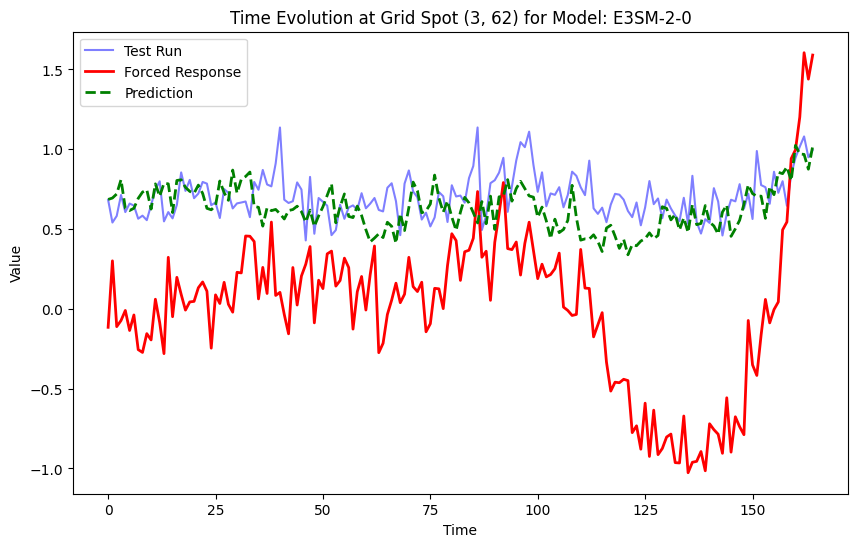

In [36]:
# Select a random grid spot
valid_grid_spots = np.argwhere(~nan_mask)
random_grid_spot = valid_grid_spots[random.randint(0, len(valid_grid_spots))]
print(f"Displaying the forced response and runs for grid spot: {random_grid_spot}")

# Data for each run (minus the forced response)
input_data = test_run.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the forced response
forced_response_data = ground_truth.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the prediction
predicted_data = prediction.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]

# Plot the time series data for all runs, the forced response, and the prediction
plt.figure(figsize=(10, 6))
plt.plot(input_data, color='blue', alpha=0.5, label='Test Run')
plt.plot(forced_response_data, color='red', label='Forced Response', linewidth=2)
plt.plot(predicted_data, color='green', label='Prediction', linewidth=2, linestyle='--')
plt.title(f'Time Evolution at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]}) for Model: {test_model}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [37]:
print(f"The shape of the data is: {X_full.shape}")
print(f"The shape of the target is: {Y_full.shape}")
print(f"The maximum, minimum, average and std for the input data are: {np.max(X_full)}, {np.min(X_full)}, {np.mean(X_full)}, {np.std(X_full)}")
print(f"The maximum, minimum, average and std for the target data are: {np.max(Y_full)}, {np.min(Y_full)}, {np.mean(Y_full)}, {np.std(Y_full)}")

The shape of the data is: (48345, 6523)
The shape of the target is: (48345, 6523)
The maximum, minimum, average and std for the input data are: 47.9123505727804, -13.770887280773467, 1.5271161311352964e-16, 0.9999999999999954
The maximum, minimum, average and std for the target data are: 6.849937139768487, -3.1231895769894615, 1.4802217305365694e-16, 0.538356100217431


Random timestamp: 121


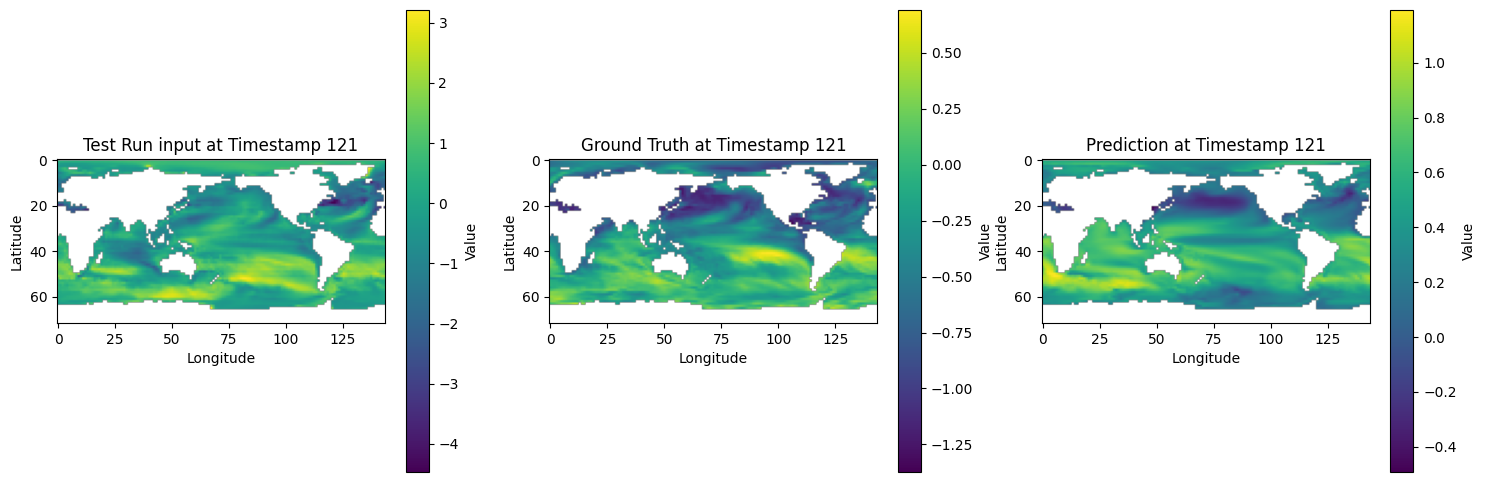

In [38]:
# Plot a random timestamp for the target and prediction

random_timestamp = random.randint(0, prediction.shape[0])
print(f"Random timestamp: {random_timestamp}")

# Data for the target
# Reshape the data to the original grid shape
test_run_grid = test_run[random_timestamp, :].reshape(72, 144)
ground_truth_grid = ground_truth[random_timestamp, :].reshape(72, 144)
prediction_grid = prediction[random_timestamp, :].reshape(72, 144)

# Plot the data using plt.imshow
plt.figure(figsize=(18, 6))

# Plot the test run
plt.subplot(1, 3, 1)
plt.imshow(test_run_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Test Run input at Timestamp {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the ground truth (forced response)
plt.subplot(1, 3, 2)
plt.imshow(ground_truth_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Ground Truth at Timestamp {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the prediction
plt.subplot(1, 3, 3)
plt.imshow(prediction_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Prediction at Timestamp {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [39]:
# Calculate the MSE of the predictions vs the ground truth
prediction.shape, ground_truth.shape

((165, 10368), (165, 10368))

## Compute the MSE for each of the runs using the RRR

In [40]:
normalized_test_data.keys()

dict_keys(['E3SM-2-0'])

Model: E3SM-2-0, Run: r1i1p1f1, MSE: 0.49067459556666665
Model: E3SM-2-0, Run: r2i1p1f1, MSE: 0.4830401626054699
Model: E3SM-2-0, Run: r3i1p1f1, MSE: 0.49617311601869074
Model: E3SM-2-0, Run: r4i1p1f1, MSE: 0.48547460303393286
Model: E3SM-2-0, Run: r5i1p1f1, MSE: 0.5057530778583084
Model: E3SM-2-0, Run: r10i1p1f1, MSE: 0.485032383832772
Model: E3SM-2-0, Run: r6i1p1f1, MSE: 0.4955958662480595
Model: E3SM-2-0, Run: r7i1p1f1, MSE: 0.49636338737150465
Model: E3SM-2-0, Run: r8i1p1f1, MSE: 0.4838883620717598
Model: E3SM-2-0, Run: r9i1p1f1, MSE: 0.48357472386043826
Model: E3SM-2-0, Run: r11i1p1f1, MSE: 0.48075689311681247
Model: E3SM-2-0, Run: r12i1p1f1, MSE: 0.4738001120211121
Model: E3SM-2-0, Run: r16i1p1f1, MSE: 0.5057012343529045
Model: E3SM-2-0, Run: r18i1p1f1, MSE: 0.5041783058412191
Model: E3SM-2-0, Run: r13i1p1f1, MSE: 0.5063364992618161
Model: E3SM-2-0, Run: r14i1p1f1, MSE: 0.5020968167151637
Model: E3SM-2-0, Run: r19i1p1f1, MSE: 0.48836519747242607
Model: E3SM-2-0, Run: r15i1p1f1, M

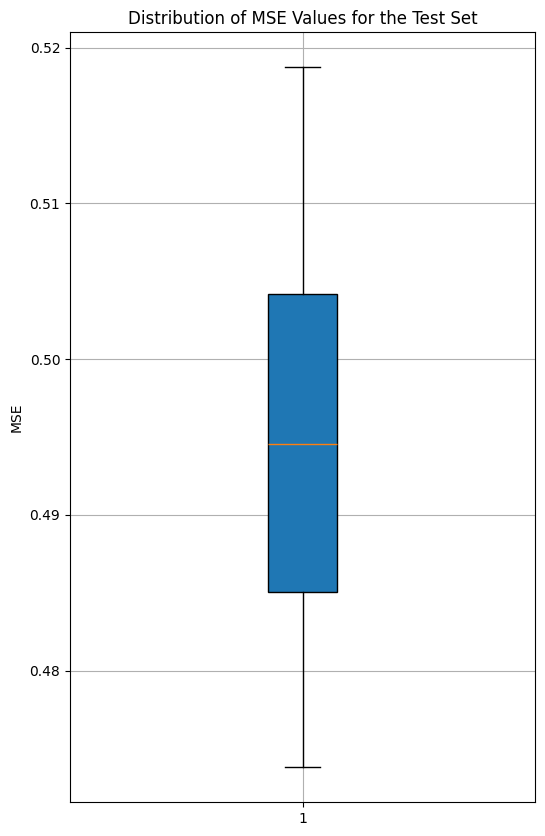

In [41]:
# Calculate the MSE for each of the runs in the test set

test_model_mse = []
for model in normalized_test_data:
    for run in normalized_test_data[model]:
        if run == 'forced_response':
            continue
        test_run = normalized_test_data[model][run]
        ground_truth = normalized_test_data[model]['forced_response']
        run_mse = calculate_mse(test_run, Brr, ground_truth)
        test_model_mse.append(run_mse)
        print(f"Model: {model}, Run: {run}, MSE: {run_mse}")
        
# Plot the distribution of the MSE values
plt.figure(figsize=(6, 10))
plt.boxplot(test_model_mse, vert=True, patch_artist=True)
plt.ylabel('MSE')
plt.title('Distribution of MSE Values for the Test Set')
plt.grid(True)
plt.show()

## Finally plot the animations of all the test runs and compare them to the ground truth

In [42]:
num_runs = 3
plot_animations(test_model, normalized_test_data, Brr, nan_mask, num_runs)

Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...


Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...


Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
